In [5]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST Original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

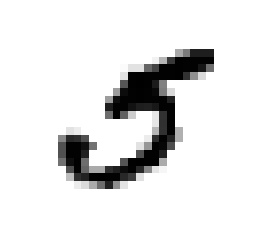

In [8]:
# Plot one of the entries by reshaping the data into a 28x28 (pixels) array
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [9]:
y[36000]

5.0

In [10]:
# Create train and test sets from data and shuffle entries
X_train,  X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[:60000]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [11]:
# Train a binary classifier for checking '5 or not 5'
# Create train and test sets with binary (1 or 0) vectors:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sdg_clf = SGDClassifier(random_state = 42) # to make reproducible
sdg_clf.fit(X_train, y_train_5)

# try to predict if the image above is a five
sdg_clf.predict([some_digit])

array([False], dtype=bool)

In [12]:
# Custom implementation of cross-validation (p. 83)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sdg_clf) # make this parameterizable?
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.95575
0.96835
0.9594


In [13]:
# Check with pre-existing cross validator
from sklearn.model_selection import cross_val_score
cross_val_score(sdg_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([ 0.95575,  0.96835,  0.9594 ])

In [14]:
# Accuracy may seem good, but compare to this "never 5" classifier:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([ 0.9115 ,  0.90855,  0.9089 ])

In [15]:
# Create a confusion matrix (p. 84)
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sdg_clf, X_train, y_train_5, cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# this creates a matrix:
# [[non-fives predicted correctly predicted as non-fives, non-fives predicted as fives],
#  [fives predicted as non-fives, fives correctly predicted as fives]]
#
# [[true negatives, false positives], 
#  [false negatives, true positives]]

array([[53786,   793],
       [ 1537,  3884]])

In [16]:
# (p.85) Calculate "precision", "recall"
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
from sklearn.metrics import precision_score, recall_score
print("Precision: ", precision_score(y_train_5, y_train_pred))
print("Recall: ", recall_score(y_train_5, y_train_pred))

# ==> predicting fives using our classifier is only correcy ~78% of the time (precision)
# ==> detecting fives works only 77% of the time (recall)

Precision:  0.83044686765
Recall:  0.716472975466


In [17]:
# (p. 86) F1-score = harmonic mean of precision and recall
# f1 = 2 / ((1 / precision) + (1 / recall))
#    = 2 * ((precision * recall) / (precision + recall))
#    = TP / (TP + ((FN + FP) / 2))
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

# Sometimes you want to tune for precision, other times for 
# recall. This is called the precision/recall tradeoff.

0.76926123984947514

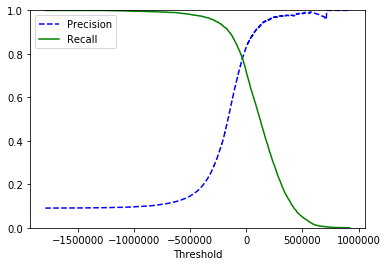

In [18]:
# (p. 88) how to decide which threshold to use 
y_scores = cross_val_predict(sdg_clf, X_train, y_train_5, cv = 3, method = "decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_vs_recall_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])
    
plot_precision_vs_recall_thresholds(precisions, recalls, thresholds)
plt.show()

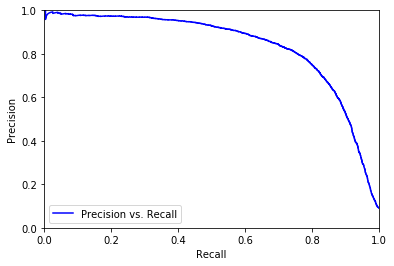

In [19]:
# Other option: plot precision vs. recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", label = "Precision vs. Recall")
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc = "lower left")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [20]:
# (p. 90) aiming for 90% precision:
y_train_pred_90 = (y_scores > 160000)   # 160,000 deduced from the first plot
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.947836635665
Recall:  0.4323925475


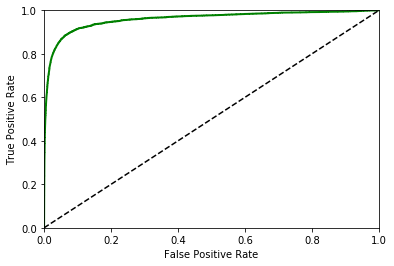

In [21]:
# (p. 91) The ROC / receiver operating characteristic curve
# specificity = true negative rate, true negs classified as such
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, "g-", linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [22]:
# (p. 92) ROC AUC = receiver operating characteristic, area under curve
# auc = 1 for perfect classifier
# auc = 0.5 for random classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95952337065272042

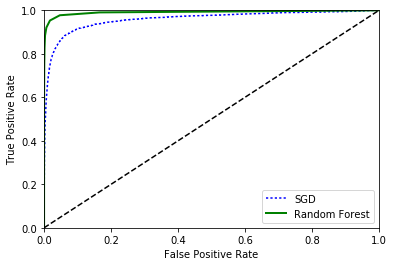

In [23]:
# (p. 92) train a RandomForestClassifier and compare
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
y_scores_forest =y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [24]:
# (p. 94) multiclass classification, sklearn does this automatically OvA
sdg_clf.fit(X_train, y_train)  # y_train, not y_train_5!
sdg_clf.predict([some_digit])

array([ 3.])

In [25]:
some_digit_scores = sdg_clf.decision_function([some_digit])
some_digit_scores

array([[ -86134.29454817, -448984.24256332, -275782.73583738,
         -48288.10152081, -434450.20703879, -143466.89827594,
        -655390.67482327, -192730.74647067, -507860.79826446,
        -753321.51738745]])

In [26]:
np.argmax(some_digit_scores)

3

In [27]:
sdg_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [28]:
sdg_clf.classes_[5]

5.0

In [29]:
# Manually create OvO or OvA classifier (p. 95)
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 3.])

In [30]:
len(ovo_clf.estimators_)

45

In [31]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [32]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [33]:
cross_val_score(sdg_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.8314837 ,  0.87539377,  0.84617693])

In [34]:
# Quite good accuracy, but gets even better with scaling (p. 96)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sdg_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.9090182 ,  0.91319566,  0.90888633])

In [35]:
# Error Analysis (p. 96)
y_train_pred = cross_val_predict(sdg_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5733,    3,   26,    9,   12,   49,   39,   10,   38,    4],
       [   2, 6479,   41,   26,    5,   44,    8,   11,  109,   17],
       [  57,   36, 5337,  105,   80,   22,   86,   63,  153,   19],
       [  50,   38,  134, 5340,    2,  246,   34,   59,  135,   93],
       [  24,   23,   35,    8, 5371,   11,   47,   29,   89,  205],
       [  64,   41,   36,  183,   71, 4615,  113,   34,  168,   96],
       [  35,   20,   41,    2,   42,   97, 5632,    6,   42,    1],
       [  20,   19,   64,   23,   54,   10,    5, 5826,   16,  228],
       [  55,  147,   65,  175,   13,  165,   62,   27, 5015,  127],
       [  41,   32,   23,   89,  154,   37,    2,  215,   82, 5274]])

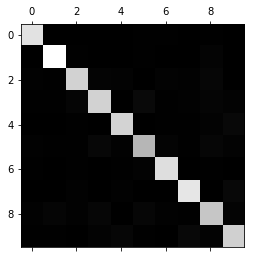

In [36]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

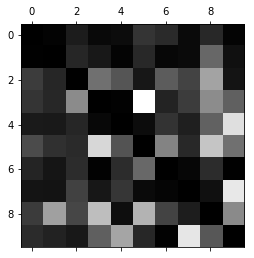

In [37]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [38]:
# (p. 99) plot_digits in not defined in the book, skipping
# (p. 100) multi-label classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])
# results in two values: if the number is large (7,8,9) and if it is odd
# for [some_digit] - which is a 5 - this yields false, true correctly

array([[False,  True]], dtype=bool)

In [39]:
# (p. 100) F1 score across all labels, aggregated
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# f1_score(y_train, y_train_knn_pred, average="macro")

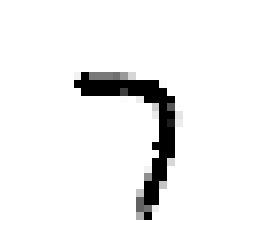

In [46]:
# (p.101) multi-output multi-class classification
#  => multiple labels in output as before, but each can have more than two values!
# example: remove noise from images (each pixel is an output value and can have 0..255 as value)

def plot_digit(digit):
    reshaped = digit.reshape(28, 28)
    plt.imshow(reshaped, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
    
    
import numpy as np

# 1) add noise to existing MNIST images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

some_index = 7500

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
# plots cleaned up image

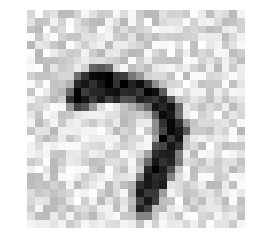

In [47]:
plot_digit(X_test_mod[some_index])
# plots non-cleaned up image with noise